In [ ]:
!pip install tensorflow-addons[tensorflow]
! apt install tesseract-ocr
! apt install libtesseract-dev
!pip install pytesseract

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import tensorflow as tf
import scipy.io as sio
#import xml.dom.minidom
import sys
import random
import time
from itertools import compress
import matplotlib.pyplot as plt
from scipy import ndimage
import glob 

import threading
import multiprocessing
try:
    import queue
except ImportError:
    import Queue as queue



#from tensorflow.python import keras

from tensorflow.python import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D,Bidirectional,LSTM
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from tensorflow.keras import applications


import tensorflow_addons as tfa
tfa_enabled = True

try:
    import tensorflow_addons as tfa
    tfa_enabled = True
except ModuleNotFoundError:
    tfa_enabled = False
    print('tfa module not available. Will be using cv2 to rotate matrices \n'
          'Error will not be back-propagated from recognition branch \n'
          'to backbone branch. This mode is proper for inference only')

tf.config.run_functions_eagerly(True)

tf.executing_eagerly()

import logging
logging.getLogger('tensorflow').disabled = True

import pytesseract
from PIL import Image


In [2]:
class Backbone(tf.keras.Model):

    

    def __init__(self,backbone='resnet', input_shape= (640,640,3), training=True):
        super(Backbone, self).__init__()

        self.training = training
        
        self.ip_shape=input_shape
        print("input:",self.ip_shape)
        if backbone == 'mobilenet':
            self.baskbone = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape)
            self.layer_ids = [153, 118, 56, 29]
        else:
            self.baskbone = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
            self.layer_ids = [174, 142, 80, 12]
        #self.baskbone = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
        #self.layer_ids = [174, 142, 80, 12]
        #self.baskbone = tf.keras.applications.MobileNetV2(input_shape= self.ip_shape,include_top=False)
        #self.layer_ids = [153, 118, 56, 29]
        
        self.backbone_name = backbone
        self.baskbone.trainable = False
        self.backbone_layers = tf.keras.models.Model(
            inputs=self.baskbone.input,
            outputs=[self.baskbone.get_layer(index=i).output for i in self.layer_ids])

        self.l1 = tf.keras.layers.Conv2D(filters=128, kernel_size=1, padding='same',name="cov2d_1")
        self.l2 = tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='same',name="cov2d_2")
        self.l3 = tf.keras.layers.Conv2D(filters=32, kernel_size=1, padding='same',name="cov2d_3")

        self.h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',name="cov2d_h1")
        self.h2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',name="cov2d_h2")
        self.h3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',name="cov2d_h3")

        # https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization
        # Scale: if True, multiply by gamma. If False, gamma is not used.
        # When the next layer is linear (also e.g. nn.relu),
        # this can be disabled since the scaling will be done by the next layer.
        self.bn1 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001,name="bn_1")
        self.bn2 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001,name="bn_2")
        self.bn3 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001,name="bn_3")

        self.g1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)

    def __call__(self, input):

        # layers extracted from Backbone model (ResNet or MobileNet):
        # 1st is the farthest one (near the end of the net),
        # 4th is the closest one (near the beggining)

        # preprocess input
       
        
        if 'mobile' in self.backbone_name.lower():
            input = tf.keras.applications.mobilenet.preprocess_input(input)
        else:
            input = tf.keras.applications.resnet50.preprocess_input(input)

        layer_1, layer_2, layer_3, layer_4 = self.backbone_layers(input)

        # step 1
        # layer_1 -> layer_1
        layer_shape = tf.shape(layer_1)
        layer_1 = tf.keras.layers.UpSampling2D(size=[2, 2])(layer_1)

        # step 2
        # layer_1 + layer_2 -> layer_12
        layer_12_conc = self.l1(tf.concat([layer_1, layer_2], axis=-1))
        layer_12_conv = self.h1(layer_12_conc)
        layer_12_conv = self.bn1(layer_12_conv)
        layer_12_conv = tf.nn.relu(layer_12_conv)
        layer_12 = tf.keras.layers.UpSampling2D(size=[2, 2])(layer_12_conv)

        # step 3
        # layer_12 + layer_3 -> layer_123
        layer_123_conc = self.l2(tf.concat([layer_12, layer_3], axis=-1))
        layer_123_conv = self.h2(layer_123_conc)
        layer_123_conv = self.bn2(layer_123_conv)
        layer_123_conv = tf.nn.relu(layer_123_conv)
        layer_123 = tf.keras.layers.UpSampling2D(size=[2, 2])(layer_123_conv)

        # step 4
        # layer_123 + layer_4 -> layer_1234
        layer_1234_conc = self.l3(tf.concat([layer_123, layer_4], axis=-1))
        layer_1234_conv = self.h3(layer_1234_conc)
        layer_1234_conv = self.bn3(layer_1234_conv)
        layer_1234_conv = tf.nn.relu(layer_1234_conv)

        layer_1234 = self.g1(layer_1234_conv)

        return layer_1234


In [3]:
class Detection(tf.keras.Model):

    

    def __init__(self):
        super(Detection, self).__init__()

        self.f_score = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation=tf.nn.sigmoid)
        self.geo_map = tf.keras.layers.Conv2D(filters=4, kernel_size=(1, 1), padding='same', activation=tf.nn.sigmoid)
        self.angle_map = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation=tf.nn.sigmoid)

    def __call__(self, input):

        f_score = self.f_score(input)
        geo_map = self.geo_map(input) * 512
        angle_map = (self.angle_map(input) - 0.5) * np.pi / 2
        f_geometry = tf.concat([geo_map, angle_map], axis=-1)

        return f_score, f_geometry

    


In [4]:
class Recognition(tf.keras.Model):

    

    def __init__(self, training=True, drop_prob=0.0):
        super(Recognition, self).__init__()
        self.drop_prob = drop_prob

        self.CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"
        self.NUM_CLASSES = len(self.CHAR_VECTOR) + 1

        # cnn
        # 1st block
        self.layer_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')
        self.bn_1 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=[2, 1], strides=[2, 1], padding='same')

        # 2nd block
        self.layer_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=[2, 1], strides=[2, 1], padding='same')

        # 3rd block
        self.layer_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.bn_3 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.pool_3 = tf.keras.layers.MaxPool2D(pool_size=[2, 1], strides=[2, 1], padding='same')

        # # rnn
        lstm_fw_cell_1 = tf.keras.layers.LSTM(128, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        lstm_bw_cell_1 = tf.keras.layers.LSTM(128, go_backwards=True, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        self.bilstm_1 = tf.keras.layers.Bidirectional(layer=lstm_fw_cell_1, backward_layer=lstm_bw_cell_1)

        lstm_fw_cell_2 = tf.keras.layers.LSTM(128, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        lstm_bw_cell_2 = tf.keras.layers.LSTM(128, go_backwards=True, unit_forget_bias=True, return_sequences=True, dropout=self.drop_prob)
        self.bilstm_2 = tf.keras.layers.Bidirectional(layer=lstm_fw_cell_2, backward_layer=lstm_bw_cell_2)

        # From the paper: To avoid overfitting on small training datasets
        # like ICDAR 2015, we add dropout before fully-connection.
        # https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout
        self.dense = tf.keras.layers.Dense(self.NUM_CLASSES)  # number of classes + 1 blank char

    def __call__(self, input):

        # 1st block
        x = self.layer_1(input)
        x = self.bn_1(x)
        x = tf.nn.relu(x)  # activation after bn
        x = self.pool_1(x)

        # 2nd block
        x = self.layer_2(x)
        x = self.bn_2(x)
        x = tf.nn.relu(x)
        x = self.pool_2(x)

        # 3nd block
        x = self.layer_3(x)
        x = self.bn_3(x)
        x = tf.nn.relu(x)
        x = self.pool_3(x)

        # rnn
        x = tf.squeeze(x, axis=[1])  # [BATCH, TIME, FILTERS] because height of tensor is now 1
        x = self.bilstm_1(x)
        x = self.bilstm_2(x)
        # print([i.sum() for i in x.numpy()])

        logits = self.dense(x)

        return logits

    

In [8]:



class ROI_rotate(object):

    """
    The basic idea begind this branch is to output croped text regions from sharedconvs
    these cropped regions (boxes) will serve as an input into recongition branch
    For example:
    input   [1, 120, 160, 32] sharedconvs
    output  [7, 8, 64, 32] where [boxes, height, width, channels]
    https://github.com/yu20103983/FOTS/blob/master/FOTS/dataset/dataReader.py
    https://stackoverflow.com/questions/55160136/tensorflow-2-0-and-image-processing
    https://github.com/tensorflow/addons
    https://databricks.com/tensorflow/tensorflow-in-3d
    https://stackoverflow.com/questions/37042748/how-to-create-a-rotation-matrix-in-tensorflow
    """

    # reshape original image to shape of sharedconvs and roi rotate it to see what are the features

   

    def __init__(self, features_stride=4, tfa_enabled=True):
        # self.features = features
        self.tfa_enabled = tfa_enabled
        self.features_stride = features_stride
        self.max_RoiWidth = int(256 / features_stride)
        self.fix_RoiHeight = int(32 / features_stride)
        self.ratio = float(self.fix_RoiHeight) / self.max_RoiWidth

    def quick_plot(self,x):

      #x=tf.constant(x)
      #proto_tensor = tf.make_tensor_proto(x)  # convert `tensor a` to a proto tensor
      #x=tf.make_ndarray(x)
      #x=tf.Session().run(x)
      # with tf.Session() as sess:

      # display encoded back to image data
      #  jpeg_bin = sess.run(x)
      #x=x.numpy()
      #cv2.imshow('org', x.astype(np.uint8))
      #print("type of x:",type(x))
      #print(x)
      plt.figure(figsize=(20, 20))
      plt.imshow(x)


    # decorating this with tf.function() throws an error: OSError: could not get source code
    # not sure why this went wrong as I've been using it with decoration previously
    # works fine on linux (because of tfa_enabled), does not work on windows
    @tf.function()
    def scanFunc(self, b_input, plot=False, expand_px=0):

        ifeatures, outBox, cropBox, angle = b_input
        # make sure box size is within image
        _, height, width, _ = ifeatures.shape
        offset_height = tf.clip_by_value(outBox[1]-expand_px, 1, height)
        offset_width = tf.clip_by_value(outBox[0]-expand_px, 1, width)
        target_height = tf.clip_by_value(outBox[3]+expand_px, 1, height - outBox[1]-expand_px)
        target_width = tf.clip_by_value(outBox[2]+expand_px, 1, width - outBox[0]-expand_px)

        cropFeatures = tf.image.crop_to_bounding_box(ifeatures, offset_height, offset_width, target_height, target_width)
        if plot:
            print("cropfeatures")
            for i in cropFeatures:
                print("i's")
                self.quick_plot(i.numpy())

        if self.tfa_enabled:
            textImgFeatures = tfa.image.rotate(cropFeatures, angles=angle)
        else:
            _, h, w, c = cropFeatures.shape
            print("w,h,expand_px:{0},{1},{2}".format(type(w),type(h),type(expand_px)))
            center = (int(w) / 2 + expand_px, int(h) / 2 + expand_px)
            width = cropBox[2] + expand_px * 4
            height = cropBox[3] + expand_px * 4
            matrix = cv2.getRotationMatrix2D(center=center, angle=math.degrees(math.atan(angle)), scale=1)  # https://stackoverflow.com/questions/10057854/inverse-of-tan-in-python-tan-1
            image = cv2.warpAffine(src=cropFeatures.numpy()[0, :, :, :], M=matrix, dsize=(w, h))
            x = int(center[0] - width / 2)
            y = int(center[1] - height / 2)
            textImgFeatures = image[y:y + height, x:x + width, :][np.newaxis, :, :, :]

        #if plot:
        #    for i in [textImgFeatures.numpy() if self.tfa_enabled else textImgFeatures][0]:
        #        self.quick_plot(i.numpy())

        # ------------- #

        # resize keep ratio
        w = tf.cast(tf.math.ceil(tf.multiply(tf.divide(self.fix_RoiHeight, cropBox[3]+expand_px*4), tf.cast(cropBox[2]+expand_px*4, tf.float64))), tf.int32)
        resize_textImgFeatures = tf.image.resize(textImgFeatures, (self.fix_RoiHeight, w))
        #if plot:
        #    for i in resize_textImgFeatures:
         #       quick_plot(i.numpy())
        w = tf.minimum(w, self.max_RoiWidth)

        # crop rotated corners
        pad_or_crop_textImgFeatures = tf.image.crop_to_bounding_box(resize_textImgFeatures, 0, 0, self.fix_RoiHeight, w)
        pad_or_crop_textImgFeatures = tf.image.pad_to_bounding_box(pad_or_crop_textImgFeatures, 0, 0, self.fix_RoiHeight, self.max_RoiWidth)
        if plot:
            for i in pad_or_crop_textImgFeatures:
                self.quick_plot(i.numpy())

        return [pad_or_crop_textImgFeatures, w]

     
       

    def __call__(self, features, brboxes, expand_w=20, plot=False, expand_px=0):

        # features = x_batch['images']
        # brboxes = x_batch['rboxes']

        
        paddings = tf.constant([[0, 0], [expand_w, expand_w], [expand_w, expand_w], [0, 0]])
        features_pad = tf.pad(features, paddings, "CONSTANT")
        features_pad = tf.expand_dims(features_pad, axis=1)  # [b, 1, h, w, c]

        btextImgFeatures = []
        ws = []
        #print("brboxes:",len(brboxes))
        # loop over images in batch
        for b, rboxes in enumerate(brboxes):

            outBoxes, cropBoxes, angles = rboxes
            outBoxes = tf.constant(outBoxes, dtype=tf.int32)
            cropBoxes = tf.constant(cropBoxes, dtype=tf.int32)
            angles = tf.constant(angles, dtype=tf.float32)

            # not sure if all is good, maybe +1 width and +1 height????
            outBoxes = tf.cast(tf.math.divide(outBoxes, self.features_stride), tf.int32)
            cropBoxes = tf.cast(tf.math.divide(cropBoxes, self.features_stride), tf.int32)

            outBoxes_xy = outBoxes[:, :2]
            outBoxes_xy = tf.add(outBoxes_xy, expand_w)
            outBoxes = tf.concat([outBoxes_xy, outBoxes[:, 2:]], axis=1)
            #print("b:",b)
            #print("rboxes:",rboxes)
            ifeatures_pad = features_pad[b]

            # for every box
            croped_ft = []
            croped_ft_w = []
            for outB, cropB, ang in zip(outBoxes, cropBoxes, angles):
                out = self.scanFunc(b_input=(ifeatures_pad, outB, cropB, ang), plot=plot, expand_px=expand_px)
                croped_ft.append(out[0])
                croped_ft_w.append(out[1])

            textImgFeatures = [tf.concat(croped_ft, axis=0), croped_ft_w]

            # the below code produces OOM because if there are many boxes,
            # tf, tile will produce a massive matrix hence for now the above solution
            # len_crop = tf.shape(outBoxes)[0]
            # ifeatures_tile = tf.tile(ifeatures_pad, [len_crop, 1, 1, 1])  # repeat matrix on 1 axis (for each box)
            # textImgFeatures = tf.scan(self.scanFunc, [ifeatures_tile, outBoxes, cropBoxes, angles],
            #                           [np.zeros((self.fix_RoiHeight, self.max_RoiWidth, channels), np.float32),
            #                            np.array(0, np.int32)])

            btextImgFeatures.append(textImgFeatures[0])
            ws.append(textImgFeatures[1])

        btextImgFeatures = tf.concat(btextImgFeatures, axis=0)
        ws = tf.concat(ws, axis=0)

        return btextImgFeatures, ws

In [ ]:
!wget --header="Host: doc-0g-40-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_81hluv81adjprjfo5ucus7r4g5c0fm3t_nonce=9cjo3mu95p9om" --header="Connection: keep-alive" "https://doc-0g-40-docs.googleusercontent.com/docs/securesc/qsegjfskkrpjhbbv9npr5i2j9ukntgkv/7c4ftda3igtk9un2eeovj3b46ene96ik/1617901650000/13641879967109176128/13641879967109176128/1Z5KR-szxBatA8TQea8URPiUw-Omo0r7j?e=download&authuser=1&nonce=9cjo3mu95p9om&user=13641879967109176128&hash=qg93oq9232694l8kc4rei4m7q41i7crl" -c -O 'checkpoints.rar'

In [ ]:
!unrar x checkpoints.rar 

In [10]:

class test_model():

  def __init__(self,cpkt_dir='checkpoints/',load_models = True,input_shape = [640, 640, 3]):

    self.cpkt_dir = cpkt_dir
    self.load_models = load_models
    self.loss_hist = []
    self.input_shape = input_shape
    self.CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"
    self.shared=Backbone(backbone='mobilenet',training=False)
    self.detect=Detection()
    self.model_RoI=ROI_rotate(tfa_enabled=True)
    self.recognize_model=Recognition(training=False)
    self.next_f=False
#model_sharedconv = Backbone(backbone='mobilenet', input_shape=input_shape, training=False)
#model_detection = Detection()
#model_RoIrotate = RoIRotate(tfa_enabled=tfa_enabled)
#model_recognition = Recognition(num_classes=len(CHAR_VECTOR)+1, training=False, drop_prob=0)

  def restore_rectangle_rbox(self,origin, geometry):

    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

  def decode_to_text(self,char_dict, decoded_out):
    return ''.join([char_dict[i] for i in decoded_out])

  def __call__(self,path,flag=1,video_flag=0,tes=0,plot=False):
    if self.load_models:
      self.shared.load_weights("checkpoints/sharedconv")
      self.detect.load_weights("checkpoints/detection")
      if (flag==1):
        self.recognize_model.load_weights("checkpoints/recognition")

# -------- #
    if (video_flag==1):
      vid = cv2.VideoCapture(path)
    while True:

        if (video_flag==1):
          self.next_f, im = vid.read()
        elif (video_flag==0):
          im = cv2.imread(path)
          im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        # im = cv2.imread('D:/data/SynthText/SynthText/13/bay+area_2_19.jpg')

        im = cv2.resize(im, (640, 640))
        new_h, new_w, _ = im.shape
        max_h_w_i = np.max([new_h, new_w])
        im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
        im_padded[:new_h, :new_w, :] = im.copy()
        im = im_padded[np.newaxis, :, :, :].astype(np.float)

        # detection
        sharedconv = self.shared(im.copy())  # x_batch['images'].shape
        f_score_, geo_score_ = self.detect(sharedconv)

        # -------- #
        score_map_thresh = 0.20
        f_score = f_score_[0, :, :, 0].numpy()
        geo_score = geo_score_[0, :, :, ].numpy()

        # filter out by score map
        xy_text = np.argwhere(f_score > score_map_thresh)
        xy_text = xy_text[np.argsort(xy_text[:, 0])]

        if len(xy_text) > 0:

            # restore to coordinates
            text_box_restored = self.restore_rectangle_rbox(origin=xy_text[:, ::-1] * 4,
                                              geometry=geo_score[xy_text[:, 0], xy_text[:, 1], :])  # N*4*2

        # filter out by average score
        # box_thresh = 0.95
        # ids = []
        # for i, box in enumerate(text_box_restored):
        #     mask = np.zeros_like(f_score_[0, :, :, :], dtype=np.uint8)
        #     mask = cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
        #     id = cv2.mean(f_score_[0, :, :, :].numpy(), mask)[0]
        #     ids.append(id)
        # text_box_restored = text_box_restored[np.array(ids) > box_thresh]

            # nms
            selected_indices = tf.image.non_max_suppression(boxes=text_box_restored[:, ::2, :].reshape((-1, 4)).astype(np.float32),
                                                        scores=f_score[xy_text[:, 0], xy_text[:, 1]],
                                                        max_output_size=50,
                                                        iou_threshold=0.01)

            #print(text_box_restored.shape[0], selected_indices.shape)

            if len(selected_indices) > 0 and (flag==1):

            # ----------- #
            # recognition

                rboxes = []
                box_coordinates, box_crops, angles = [], [], []
                for i in selected_indices:
                    bb = text_box_restored[i]

                    bb_corrds = int(bb[0, 0]), int(bb[0, 1]), int((bb[:, 0].max() - bb[:, 0].min())), int((bb[:, 1].max() - bb[:, 1].min()))
                    bb_corrds = list(bb_corrds)
                    bb_corrds_ = bb_corrds.copy()
                    bb_corrds_[0:2] = 0, 0
                    angle = geo_score[xy_text[i, :][1], xy_text[i, :][0]][-1]

                    box_coordinates.append(bb_corrds)
                    box_crops.append(bb_corrds_),
                    angles.append(angle)
                rboxes = [[box_coordinates, box_crops, angles]]

            # indices = xy_text[selected_indices, :]
            # indices[:, 0], indices[:, 1] = indices[:, 1].copy(), indices[:, 0].copy()
            # height = geo_score[indices[:, 0], indices[:, 1], :][:, 0:2].sum(axis=1)
            # width = geo_score[indices[:, 0], indices[:, 1], :][:, 2:4].sum(axis=1)
            # angle = geo_score[indices[:, 0], indices[:, 1], :][:, -1]
            #
            # text_coords = np.concatenate([indices, height.reshape(-1, 1), width.reshape(-1, 1)], axis=1).astype(np.int)
            # text_crop = text_coords.copy()
            # text_crop[:, 0:2] = 0
            # rboxes = [[text_coords.tolist(), text_crop.tolist(), angle.tolist()]]

                
                #print(features)
                
                features, ws = self.model_RoI(sharedconv, rboxes, expand_px=0, plot=plot)  # x_batch['rboxes']
                logits = self.recognize_model(features)

                decoded, log_prob = tf.nn.ctc_greedy_decoder(logits.numpy().transpose((1, 0, 2)),
                                                         sequence_length=[64] * logits.shape[0])
                decoded = tf.sparse.to_dense(decoded[0]).numpy()
                recognition = [self.decode_to_text(self.CHAR_VECTOR, [j for j in i if j != 0]) for i in decoded]
                #print(recognition)
                
            elif( tes == 1):
              recognition=[]
              for i, box in enumerate(text_box_restored[selected_indices, :, :]):
                
                box=box.astype(np.int32)
                
                if (tes==1):
                  x1=box[0][0]
                  y1=box[0][1]
                  x2=box[2][0]
                  y2=box[2][1]
                  #plt.figure(figsize=(2, 2))

                  roi = im_padded[y1:y2, x1:x2].copy()
                  
                  if(roi.size>3):
                    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
                    #plt.imshow(roi)
                    image = Image.fromarray(roi)
                    #config = ('-l eng --oem 1 --psm 3')
                    text = pytesseract.image_to_string(image, lang='eng', config="--oem 1 --psm 6")
                    #print(text)
                    recognition.append(text)
                  else:
                    recognition.append("###")

                  
                  

        # plot boxes
            if (tes==1) and (flag==0):
               for i, box in enumerate(text_box_restored[selected_indices, :, :]):

                 box=box.astype(np.int32)
                 im_padded = cv2.polylines(im_padded[:, :, :].copy(), [box], True, color=(255, 255, 0), thickness=1)

            # Draw recognition results area
                 if len(selected_indices) > 0:
                    text_area = box.copy()
                    
                    text_area[2, 1], text_area[3, 1], text_area[0, 1], text_area[1, 1] = text_area[1, 1], text_area[0, 1], text_area[0, 1] - 15, text_area[1, 1] - 15
                    im_padded = cv2.fillPoly(im_padded.copy(), [text_area.astype(np.int32).reshape((-1, 1, 2))], color=(255, 255, 0))
                    im_padded = cv2.putText(im_padded.copy(), recognition[i], (box.astype(np.int32)[0, 0], box.astype(np.int32)[0, 1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        #print("Recognition Texts:",recognition)
        plt.figure(figsize=(20, 20))
        #plt.subplot(4, 1, 1)
        #plt.imshow(im_padded.astype(np.uint8))
        #plt.subplot(4, 1, 2) 
        detection = cv2.resize(f_score_.numpy().copy()[0, :, :, :], im_padded.shape[:2]) * 255
        #plt.imshow(detection.astype(np.uint8))
        detection = cv2.merge((detection, detection, detection)).astype(np.uint8) * 255
        #plt.subplot(4, 1, 3)
        #plt.imshow(detection.astype(np.uint8))
        im_padded = np.concatenate([im_padded, detection], axis=1)
        #plt.subplot(4, 1, 4)
        plt.imshow(im_padded.astype(np.uint8))
        # cv2.waitKey(0)

    # RoIrotate_test = RoIRotate(features_stride=1)
    # _, _ = RoIrotate_test(im, rboxes, expand_px=1, plot=True)  # x_batch['rboxes']
        #return recognition
        if (video_flag==1):
          if (self.next_f==False):
            print("Video Ended")
            vid.release()
           #   cv2.destroyAllWindows()
            return recognition
        else:
          return recognition

**Test with Custom Image:**

input: (640, 640, 3)
9412608/9406464 [==============================] - 0s 0us/step


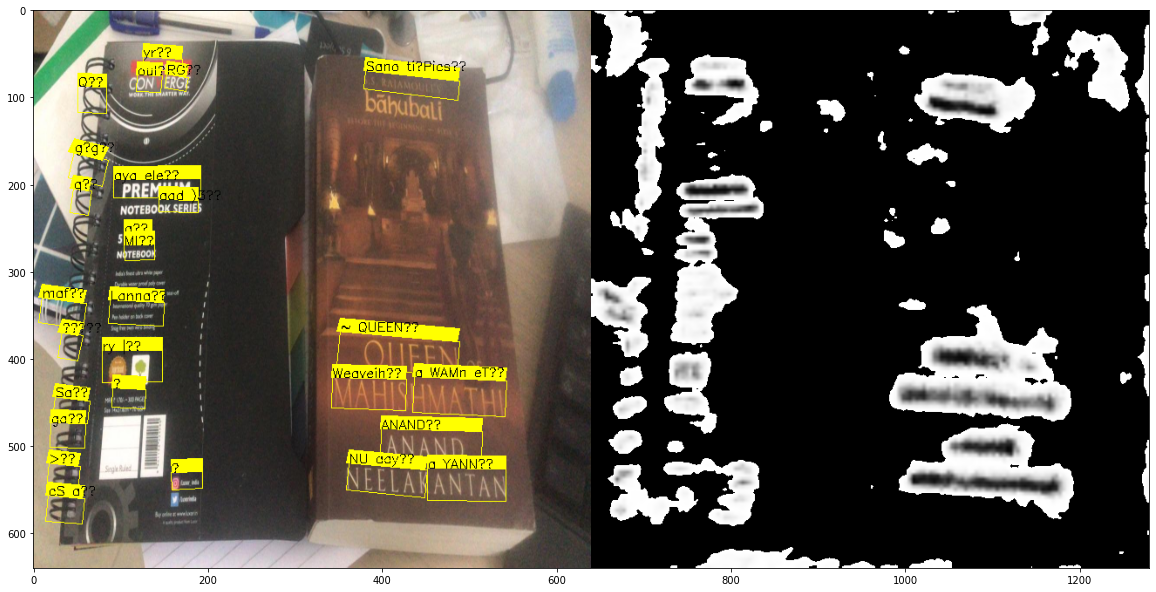

In [10]:
###########################################################
#
# params:
# init -> cpkt_dir='checkpoints/',load_models = True,input_shape = [640, 640, 3]
# call -> path,flag=1,video_flag=0,tes=0,plot=False
#  for ploting ROI,please uncomment plt in if(tes==1) loop.
#######################################################

path="real3.jpg"
detecttest=test_model()
recognition=detecttest(path,flag=0,plot=False,tes=1)